In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import average_precision_score
from IPython.display import Audio, display
import os
#import librosa
import warnings
from scipy.stats import entropy
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
classifier_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_crnn_classifier_frame'
separator_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_rnn_separator_crnn_classifier_frame_frozen'
# classifier_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_crnn_classifier_clip'
# separator_dir = '/scratch/jtc440/cdsd/models/pishdadian2020_rnn_separator_crnn_classifier_clip_frozen'

In [3]:
classifier_train_history = os.path.join(classifier_dir, "history.csv")
separator_train_history = os.path.join(separator_dir, "history.csv")

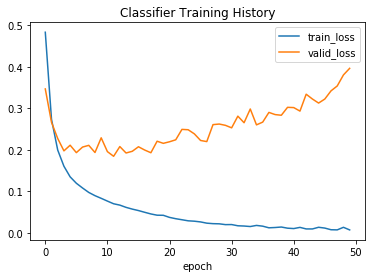

In [4]:
classifier_history = pd.read_csv(classifier_train_history)
classifier_history.plot(x='epoch', title='Classifier Training History')

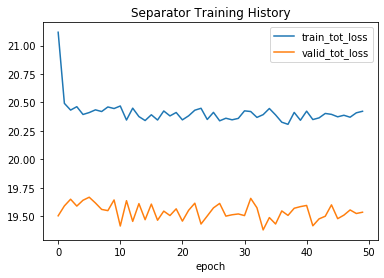

In [5]:
separator_history = pd.read_csv(separator_train_history)
separator_history.plot(x='epoch', y=['train_tot_loss', 'valid_tot_loss'], title='Separator Training History')

In [6]:
sep_res_path = os.path.join(separator_dir, 'separation_results_test.csv')

In [7]:
sep_df = pd.read_csv(sep_res_path)

In [8]:
sep_df['dog_bark_sisdr_improvement'].median()

-63.0311336517334

In [9]:
sep_df.keys()

Index(['Unnamed: 0', 'filenames', 'car_horn_input_sisdr',
       'dog_bark_input_sisdr', 'gun_shot_input_sisdr',
       'jackhammer_input_sisdr', 'siren_input_sisdr',
       'car_horn_sisdr_improvement', 'dog_bark_sisdr_improvement',
       'gun_shot_sisdr_improvement', 'jackhammer_sisdr_improvement',
       'siren_sisdr_improvement', 'mixture_dbfs', 'isolated_car_horn_dbfs',
       'isolated_dog_bark_dbfs', 'isolated_gun_shot_dbfs',
       'isolated_jackhammer_dbfs', 'isolated_siren_dbfs',
       'reconstructed_car_horn_dbfs', 'reconstructed_dog_bark_dbfs',
       'reconstructed_gun_shot_dbfs', 'reconstructed_jackhammer_dbfs',
       'reconstructed_siren_dbfs', 'car_horn_presence_gt',
       'dog_bark_presence_gt', 'gun_shot_presence_gt',
       'jackhammer_presence_gt', 'siren_presence_gt', 'mixture_pred_car_horn',
       'mixture_pred_dog_bark', 'mixture_pred_gun_shot',
       'mixture_pred_jackhammer', 'mixture_pred_siren',
       'isolated_car_horn_pred_car_horn', 'isolated_car_ho

In [10]:
labels = [x.replace('_input_sisdr', '') for x in sep_df.keys() if x.endswith('_input_sisdr')]

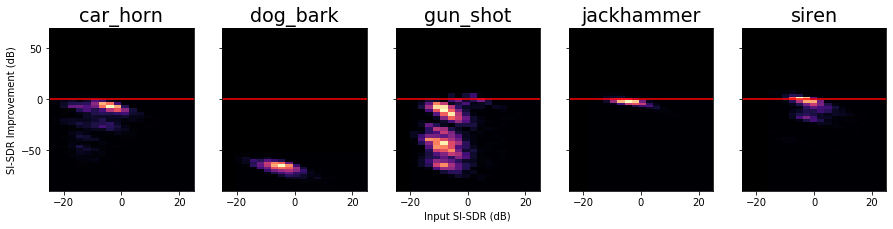

In [11]:
fig, axes = plt.subplots(ncols=len(labels), figsize=(15, 3), sharey=True)
plt.rcParams.update({'font.size': 16})
for idx, label in enumerate(labels):
    mask = sep_df[label + '_presence_gt'].to_numpy().astype(bool)
    input_sisdr = sep_df[label + '_input_sisdr'].to_numpy()[mask]
    impro_sisdr = sep_df[label + '_sisdr_improvement'].to_numpy()[mask]

    ax = axes[idx]
    ax.set_title(label)
    if idx == 0:
        ax.set_ylabel('SI-SDR Improvement (dB)')
    if idx == (len(labels) // 2):
        ax.set_xlabel('Input SI-SDR (dB)')
    
    ax.hist2d(input_sisdr, impro_sisdr, bins=50, cmap='magma')
    ax.set_ylim([-90, 70])
    ax.set_xlim([-25, 25])
    ax.set_facecolor('black')
    ax.axhline(y=0, color='red')
    fig.patch.set_facecolor('white')
    

In [12]:
y_gt = []
y_pred = []
y_pred_thresh = []
class_ap_score = {}
class_acc_score = {}
for label in labels:
    y_gt_cls = np.array(sep_df[label + '_presence_gt'].to_list(), dtype=int)
    y_pred_cls = sep_df['mixture_pred_' + label].to_list()
    y_gt.append(y_gt_cls)
    y_pred.append(y_pred_cls)
    y_pred_cls_thresh = (np.array(y_pred_cls) >= 0.5).astype(int)
    class_acc_score[label] = (y_gt_cls == y_pred_cls_thresh).astype(float).mean()
    class_ap_score[label] = average_precision_score(y_gt_cls, y_pred_cls)
y_gt = np.array(y_gt).T
y_pred = np.array(y_pred).T
y_pred_thresh = np.array(y_pred_thresh).T

TypeError: '>=' not supported between instances of 'numpy.ndarray' and 'float'

In [ ]:
np.array(y_gt_cls).shape

In [ ]:
for label in labels:
    gt_key = label + "_presence_gt"
    print("{} clip-level ratio: {}".format(label, sep_df[gt_key].mean()))

In [42]:
cm = []
cooccurrence = []
thresholds = {label: 0.5 for label in labels}
for label_idx, label in enumerate(labels):
    pos_gt_idxs = y_gt[:, label_idx].nonzero()[0]
    cooccurrence.append(y_gt[pos_gt_idxs, :].mean(axis=0))
    
    fn_idxs = (y_pred[pos_gt_idxs, label_idx] < thresholds[label]).nonzero()[0]
    cm.append((y_pred[pos_gt_idxs, :][fn_idxs, :] > thresholds[label]).mean(axis=0))
cm = np.array(cm)
cooccurrence = np.array(cooccurrence)

([<matplotlib.axis.YTick at 0x2adf4e3e1e10>,
 <a list of 5 Text yticklabel objects>)

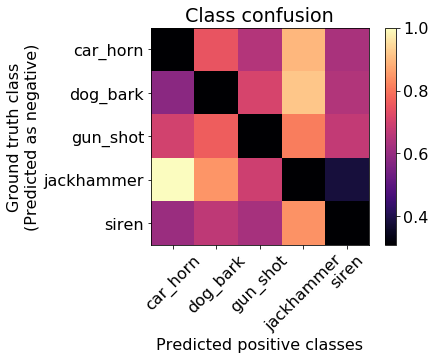

In [43]:
cm_min = cm[cm != 0].min()

plt.imshow(cm, aspect=1, cmap='magma', vmin=cm_min * 0.8, vmax=1)
plt.colorbar()
plt.ylabel('Ground truth class\n(Predicted as negative)')
plt.xlabel('Predicted positive classes')
plt.title('Class confusion')
plt.xticks(range(len(labels)), labels=labels, rotation=45)
plt.yticks(range(len(labels)), labels=labels)

([<matplotlib.axis.YTick at 0x2adf4e48d550>,
 <a list of 5 Text yticklabel objects>)

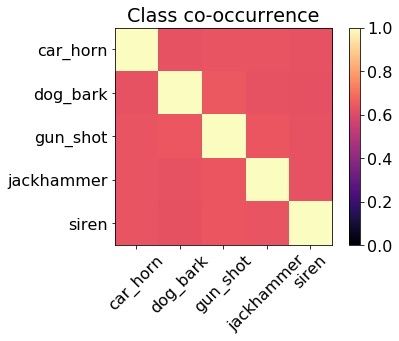

In [44]:
plt.imshow(cooccurrence, aspect=1, cmap='magma', vmin=0, vmax=1)
plt.colorbar()
plt.title('Class co-occurrence')
plt.xticks(range(len(labels)), labels=labels, rotation=45)
plt.yticks(range(len(labels)), labels=labels)

Text(0.5, 1.1, 'Model activation distributions')

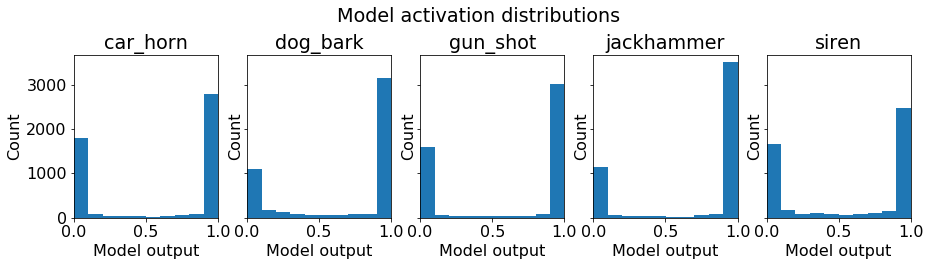

In [45]:
fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(15, 3), sharey=True)
for idx, (label, y) in enumerate(zip(labels, y_pred.T)):
    ax = axes[idx]
    ax.hist(y)
    ax.set_title(label)
    ax.set_ylabel('Count')
    ax.set_xlabel('Model output')
    ax.set_xlim([0, 1.0])
    #plt.yscale('log')
fig.suptitle("Model activation distributions", y = 1.1)

In [46]:
class_acc_score

{'car_horn': 0.9464,
 'dog_bark': 0.9296,
 'gun_shot': 0.9664,
 'jackhammer': 0.8972,
 'siren': 0.9054}

In [47]:
average_precision_score(y_gt, y_pred, average='macro')

0.9934572560640376

In [48]:
class_ap_score

{'car_horn': 0.9944835843637191,
 'dog_bark': 0.9947264231622639,
 'gun_shot': 0.997593023808786,
 'jackhammer': 0.9939360699030475,
 'siren': 0.9865471790823721}

In [13]:
recon_dir = os.path.join(separator_dir, "reconstructed_audio")

In [46]:
target_label = "dog_bark"
ex_idx = 120

In [47]:
pos_filenames = sep_df[sep_df[target_label + "_presence_gt"] == 1]["filenames"].tolist()
fname = pos_filenames[ex_idx]
audio_path = os.path.join(recon_dir, "{}_{}_recon.mp3".format(fname, target_label))
display(Audio(filename=audio_path))
sep_df[sep_df["filenames"]==fname][[x + "_presence_gt" for x in labels]]

,car_horn_presence_gt,dog_bark_presence_gt,gun_shot_presence_gt,jackhammer_presence_gt,siren_presence_gt
194,1.0,1.0,1.0,1.0,0.0


In [49]:
label_rms_lists = {}
for label in labels:
    pos_filenames = sep_df[sep_df[label + "_presence_gt"] == 1]["filenames"].tolist()
    rms_list = []
    for fname in pos_filenames:
        audio_path = os.path.join(recon_dir, "{}_{}_recon.mp3".format(fname, target_label))
        audio, sr = librosa.load(audio_path, sr=None)
        rms = np.sqrt(np.mean(audio.flatten() ** 2))
        rms_list.append(rms)
    label_rms_lists[label] = rms_list

In [ ]:
rms_max = 0.0
for rms_list in label_rms_lists.values():
    rms_max = max(np.max(rms_list), rms_max)

In [ ]:
rms_max

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=len(labels), figsize=(15, 3), sharey=True)
for idx, (label, rms_list) in enumerate(label_rms_lists.items()):
    ax = axes[idx]
    ax.hist(rms_list)
    ax.set_title(label)
    if idx == 0:
        ax.set_ylabel('Count')
    if idx == (len(labels) // 2):
        ax.set_xlabel('RMS')
    ax.set_xlim([0, rms_max * 1.1])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    #plt.yscale('log')
fig.suptitle("RMS distributions", y = 1.1)